In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime
from scipy import signal
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick

import importlib
importlib.reload(fetch_data)

start_date_str = '2023-05-30'
end_date_str = '2023-06-01'
organization_id = 'hamid'
can_k3y_id = '9ed5b50e'
imu_k3y_id = '78f8031e'

In [2]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)
raw_acc_df, raw_gyro_df = fetch_data.get_raw_data(imu_k3y_id, organization_id, start_date_str, end_date_str)
start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')
time_df = correct_drift.fetch_time_data(imu_k3y_id, organization_id, start_date, end_date)

['hamid/k3y-78f8031e/accel/raw_2023-05-30_01-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_02-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_03-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_04-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_05-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_06-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_07-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_09-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_10-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_11-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_13-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_14-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_15-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_16-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_17-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-30_18-00-00.parquet', 'hamid/k3y-78f8031e/accel/raw_2023-05-3

In [3]:
raw_df = correct_drift.shift_time(raw_acc_df, time_df)

1
1685492115.0689595


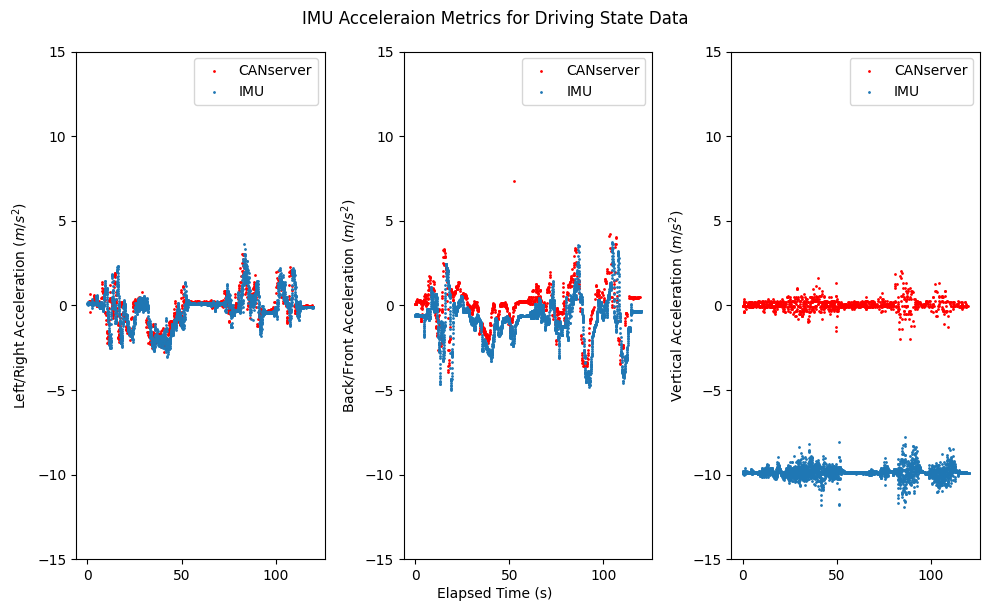

2
1685492234.8786905


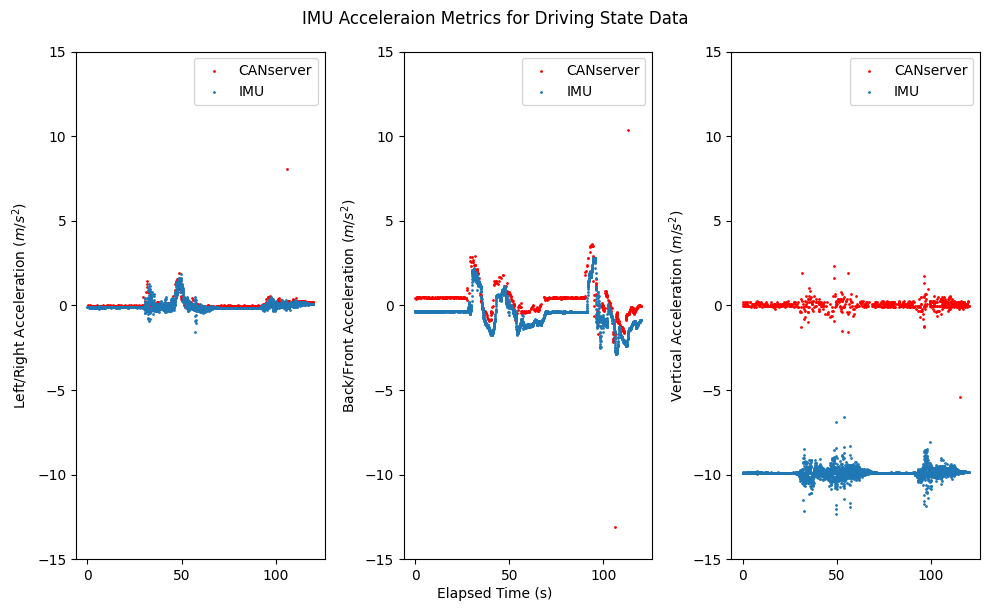

3
1685492354.6884215


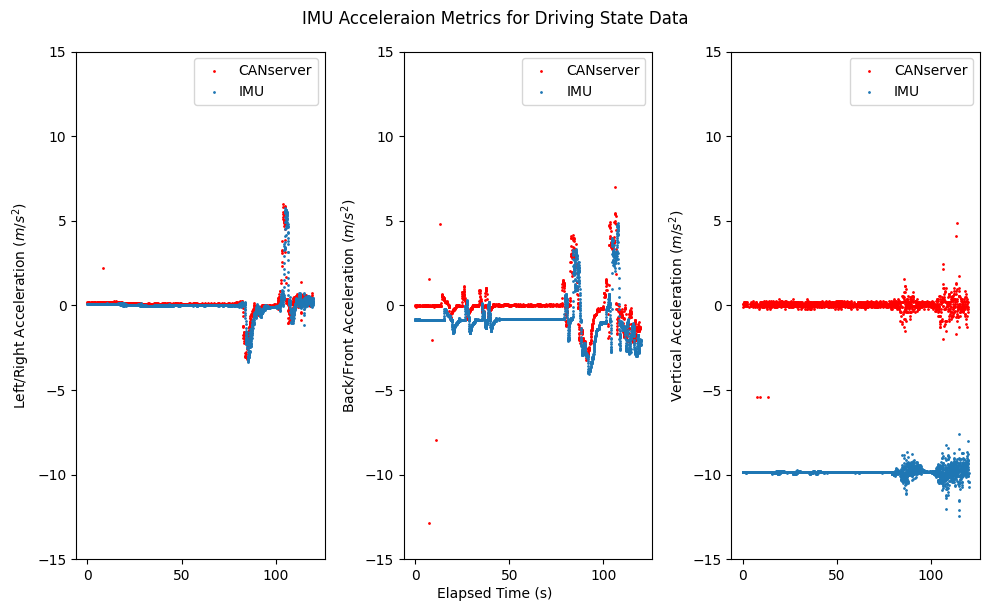

4
1685544295.615605


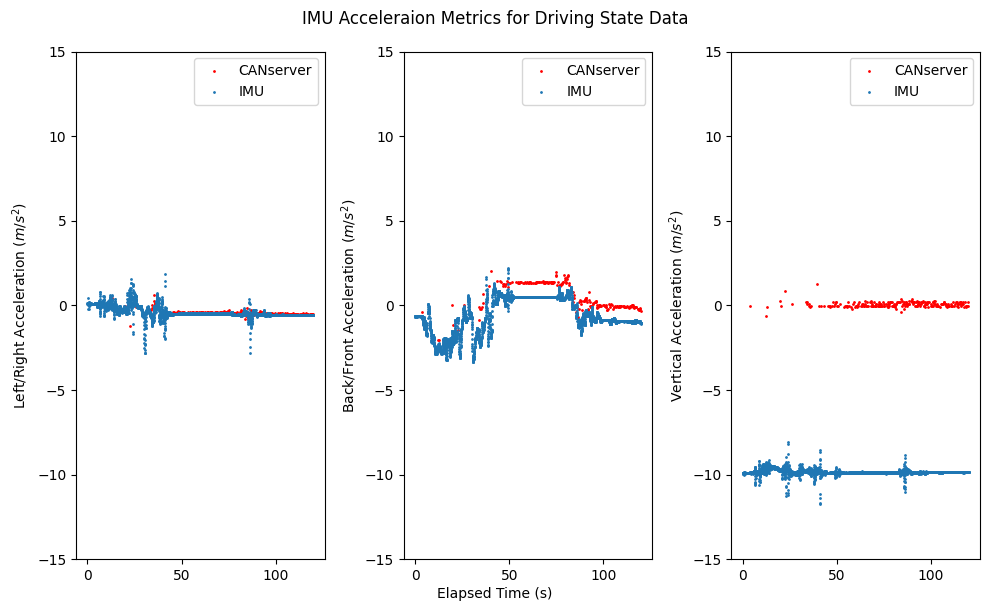

5
1685544415.458626


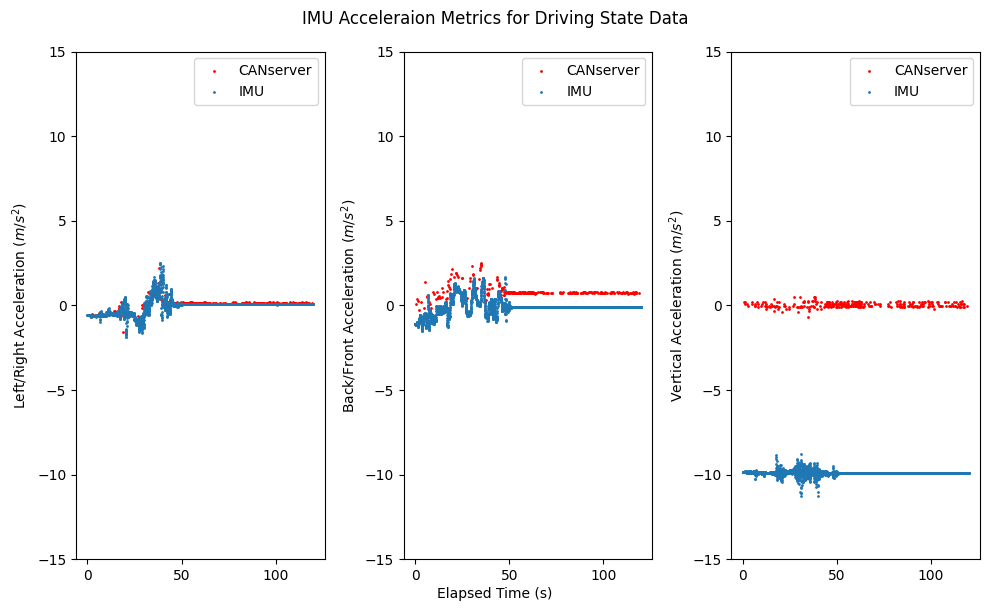

6
1685550032.2679827


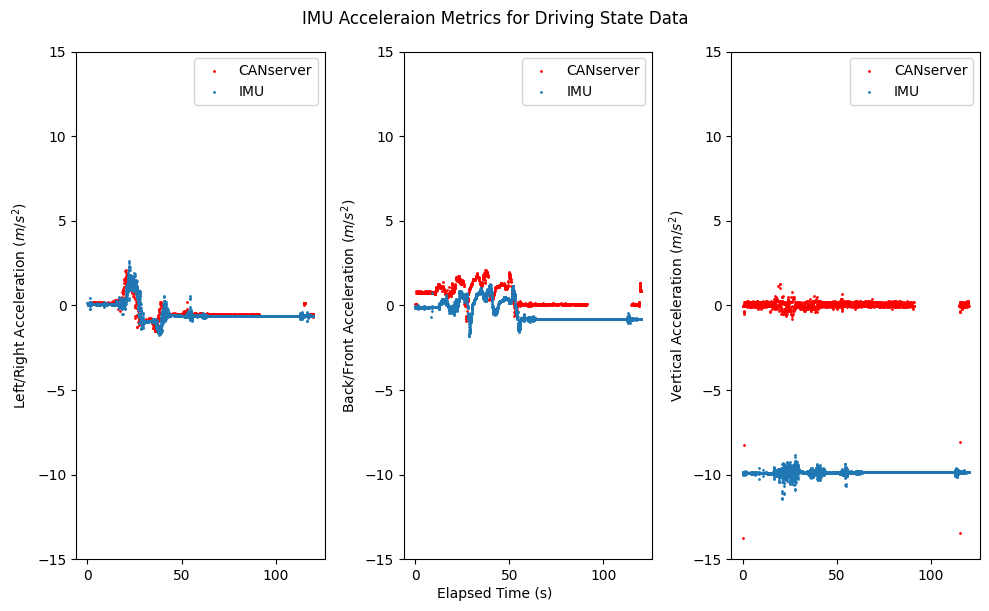

7
1685550152.1110036


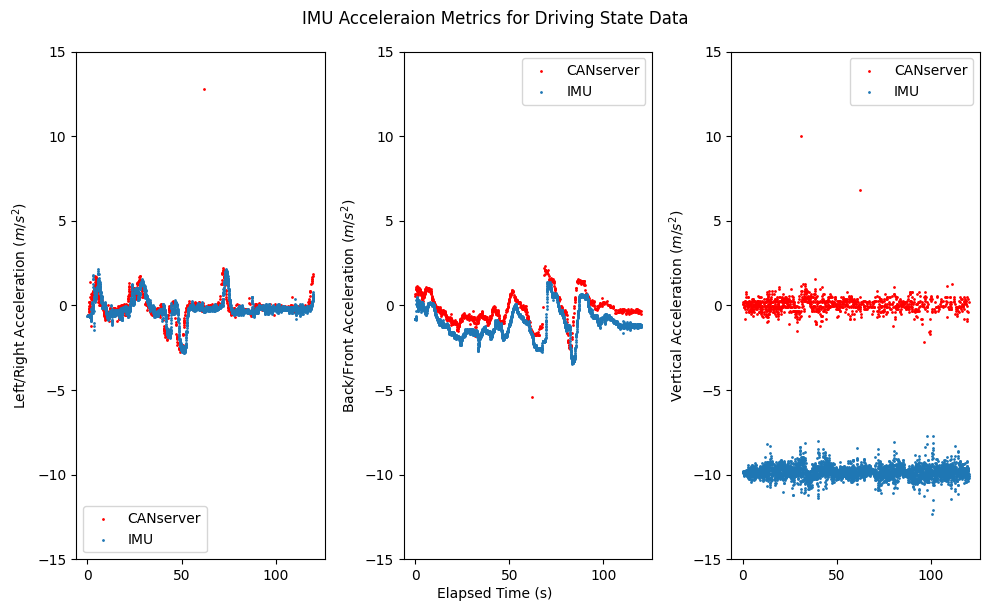

8
1685550271.9207346


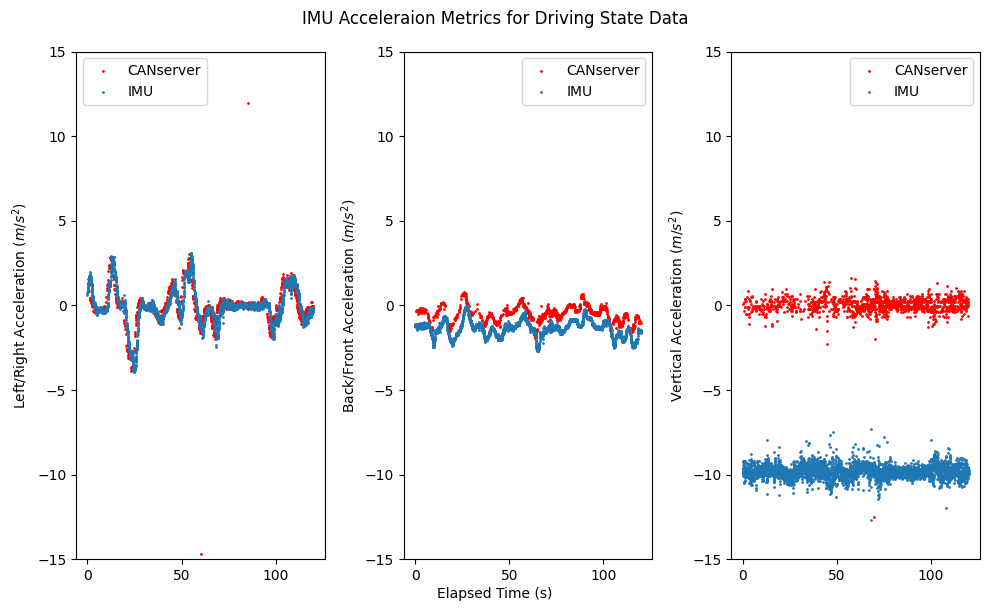

9
1685550391.730466


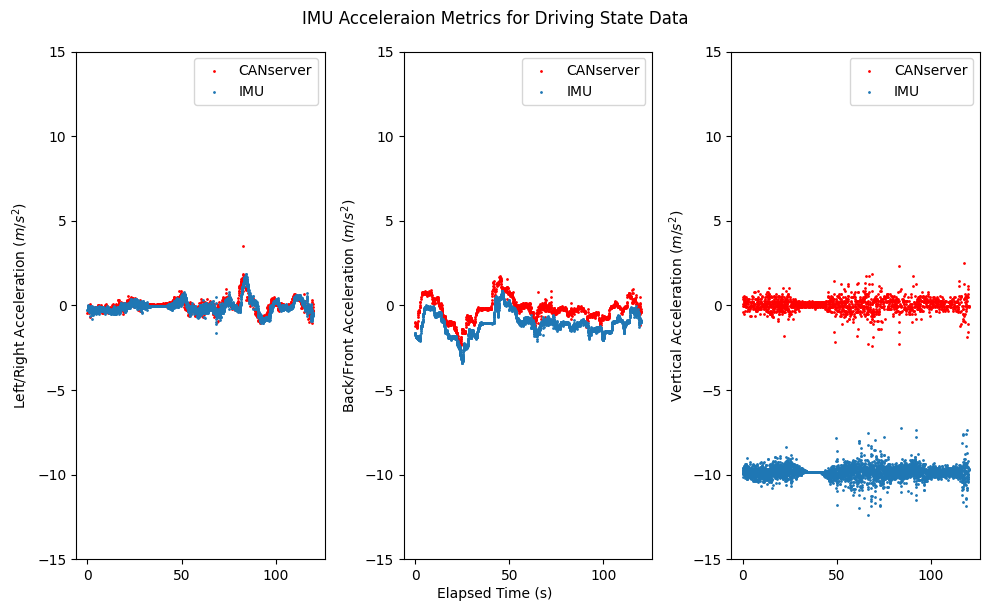

10
1685550511.5734863


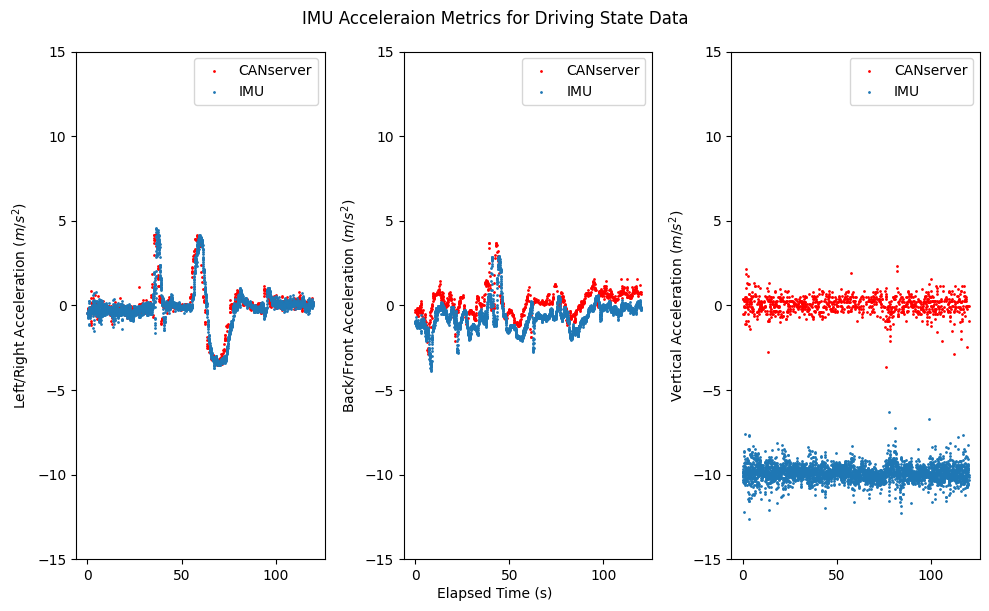

11
1685550631.3832176


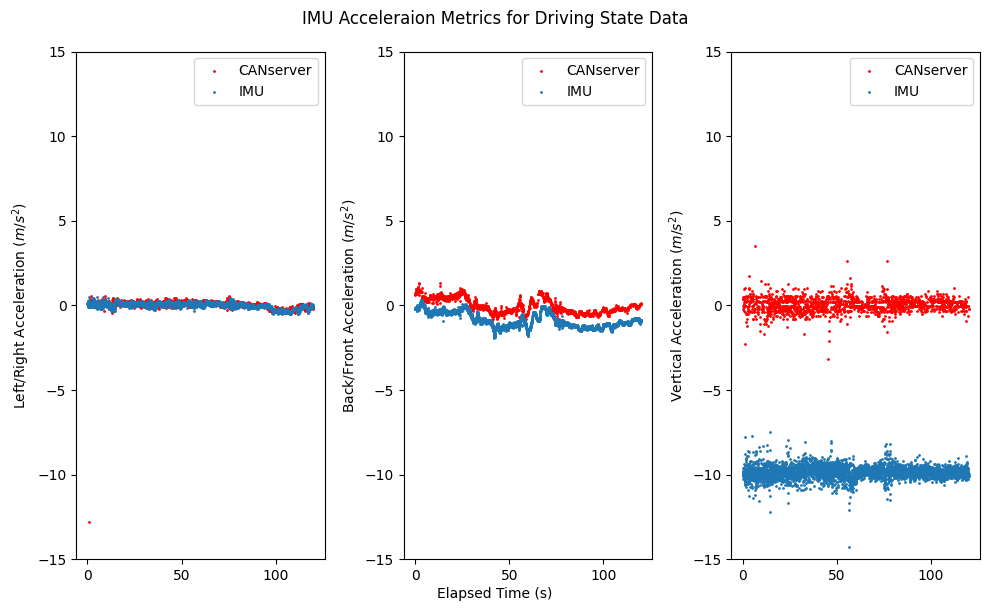

12
1685550751.2262385


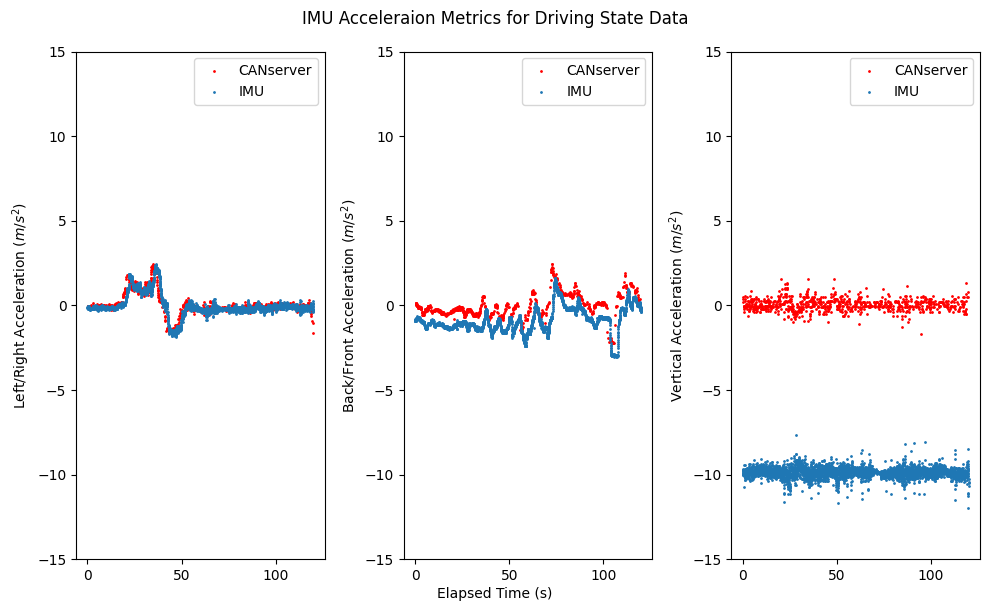

13
1685550871.0359695


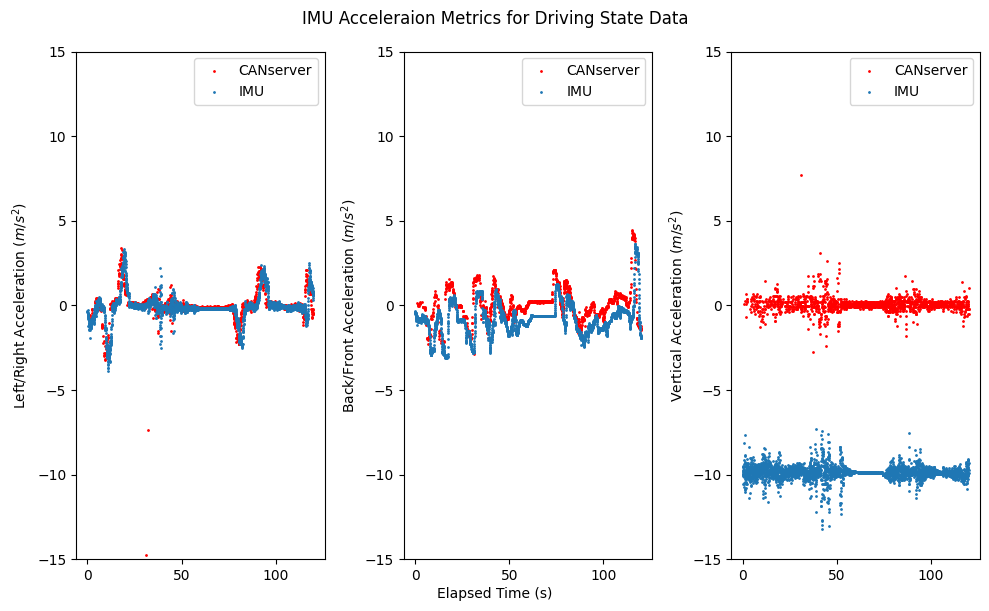

14
1685550990.8789904


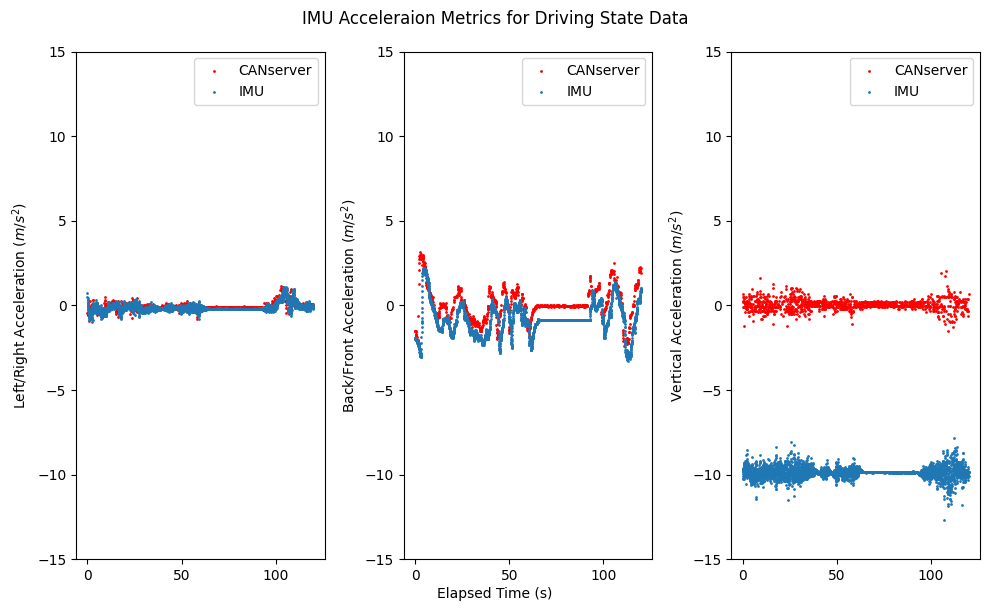

15
1685551110.6887214


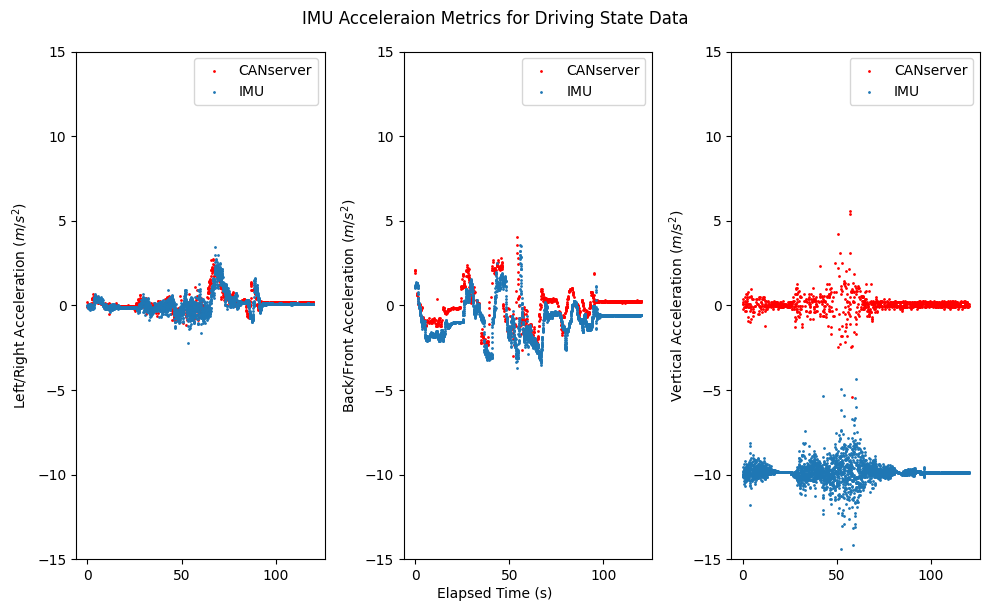

16
1685581001.4921315


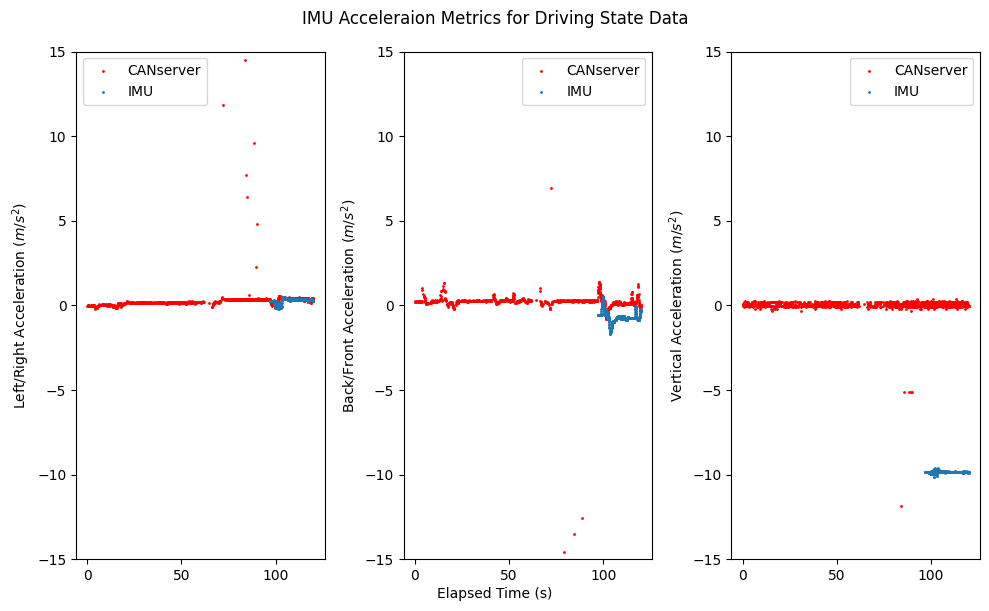

17
1685581024.528623


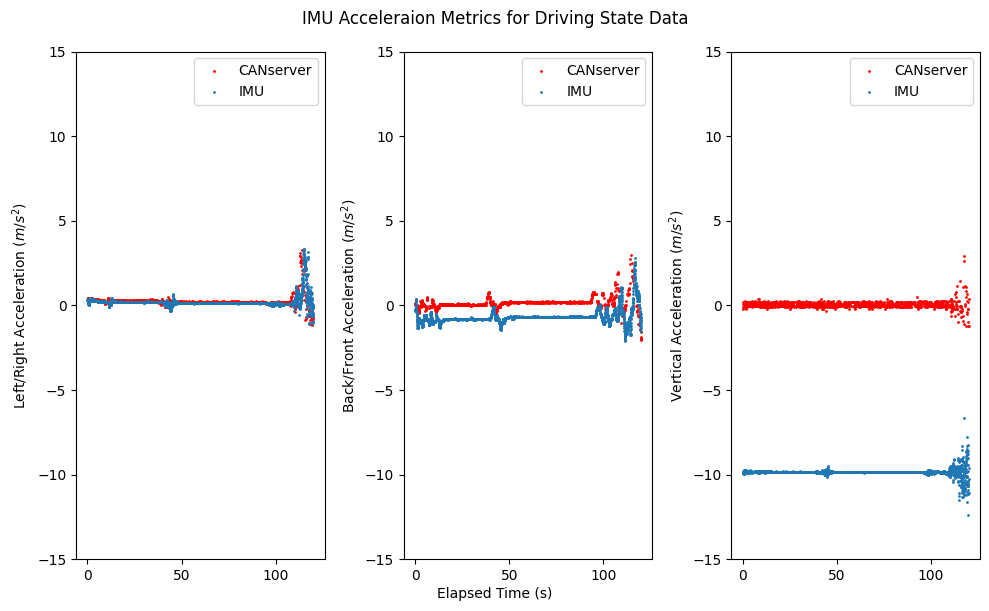

18
1685581144.5048032


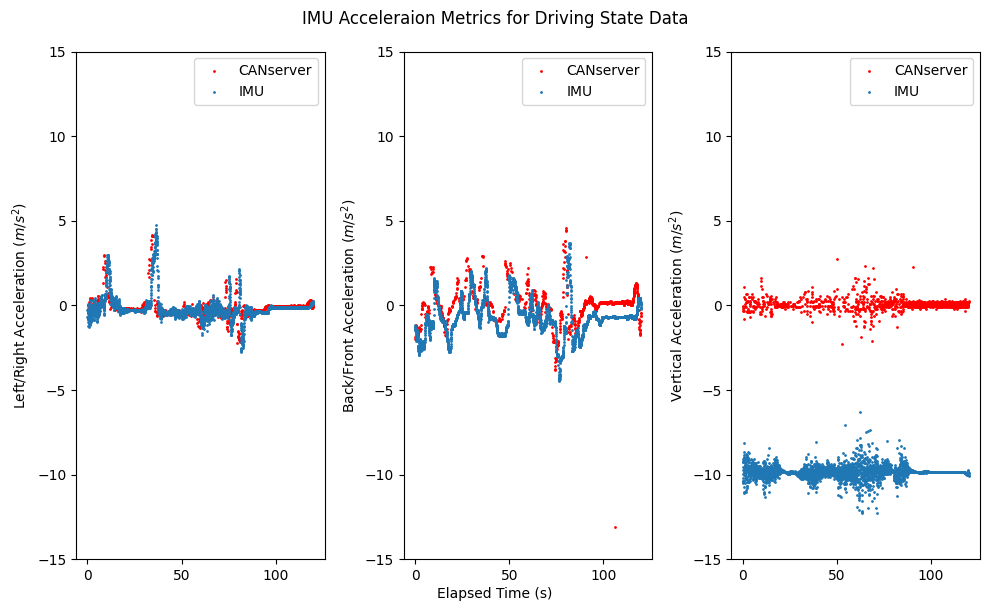

19
1685581264.5142725


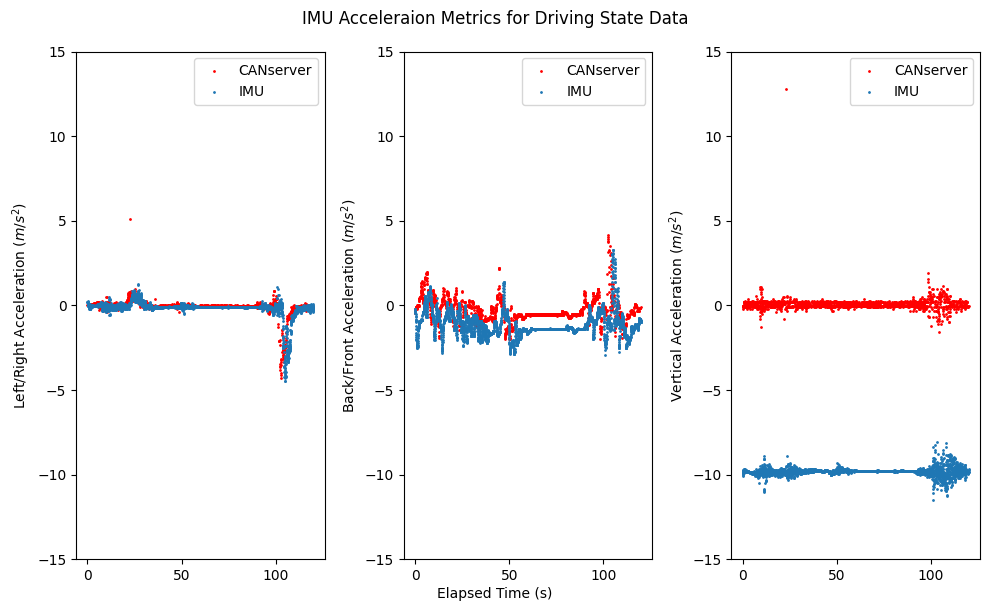

20
1685581384.4904523


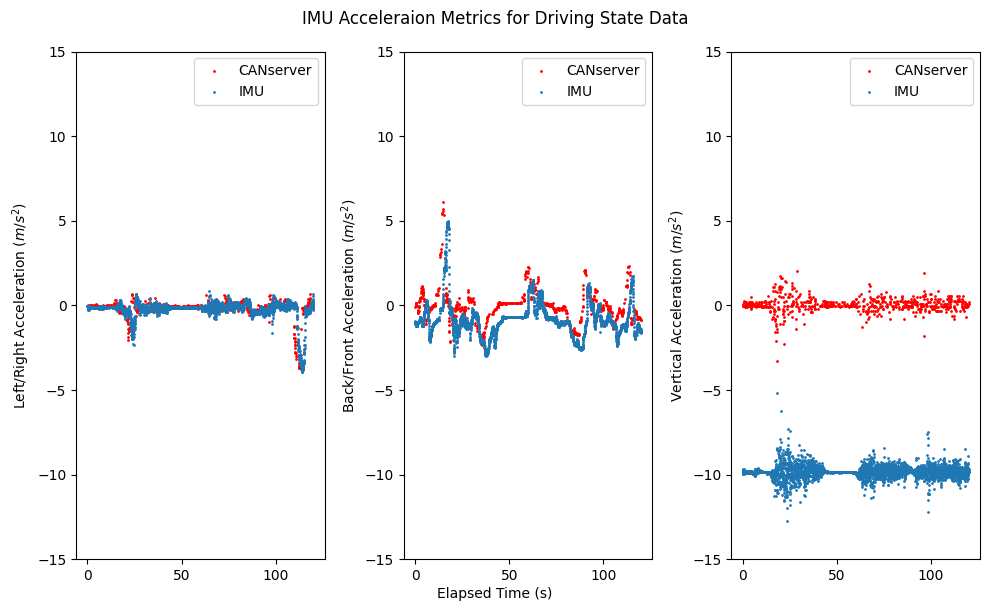

In [7]:
# plot driving state data in intervals of 120 seconds

window = 120
count = 0
can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = raw_df[(raw_df['correct_timestamp'] >= dr_start_time) 
                        & (raw_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
            count += 1
            print(count)
            print(dr_motion['timestamp(epoch in sec)'].iloc[0])
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            lr_mean = dr_motion['lr_acc(m/s^2)'].mean()
            bf_mean = dr_motion['bf_acc(m/s^2)'].mean()
            vert_mean = dr_motion['vert_acc(m/s^2)'].mean()
            lr_can_mean = can_motion['lr_acc'].mean()
            bf_can_mean = can_motion['bf_acc'].mean()
            vert_can_mean = can_motion['vert_acc'].mean()

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=-dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()